### 1. HW 2 setup

#### Libraries

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import dotenv
import os
import quandl
import datetime
from tqdm import tqdm as tqdm
import time 

# importing backtester
from modules.backtester import simulate, get_mday_returns

# importing quandl key
QUANDL_KEY = dotenv.get_key(dotenv.find_dotenv(), 'QUANDL_KEY')

#### Data Fetch Functions

In [2]:
# Helper functions
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    # path to folder downloads
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    # path to file needed
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    # if avoiding new download, and specific zip file exists, return without downloading (cache?)
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    # Get directory of file needed
    table_dir = os.path.dirname(data_symlink)
   
    # Create directory if it does not exist
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir)
        print(f'{table_dir} created!')

    # create file date for the file name string
    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override

    # create full path of data_file
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")
    print(f'{data_file=}')

    # Checks if file simply needs to be updated
    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    # Download table as zip file
    dl = quandl.export_table(
        table_path, filename=data_file, api_key=QUANDL_KEY, **kwargs)
    
    file_size = os.stat(data_file).st_size

    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

### 2. Data Setup

My student ID is 12196797 -- so using 7 for my pair: KXI XLP, where my returns will look at ret(KXI) - ret(XLP)

In [232]:
# getting EOD table from quandl
df = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False)
display(df.head())
# importing Fama-French factor returns over the same time period
ff_df = pd.read_csv('./data/Developed_3_Factors.csv')
display(ff_df.head())

data_file='/Users/erouhani/quandl_data_table_downloads/QUOTEMEDIA/PRICES_20240125.zip'
Data file /Users/erouhani/quandl_data_table_downloads/QUOTEMEDIA/PRICES_20240125.zip size 1495529923 exists already, no need to download


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,GUT_P_A,2018-07-26,25.6500,25.6500,25.6500,25.6500,2055.0,0.0,1.0,21.586931,21.586931,21.586931,21.586931,2055.0
1,GUT_P_A,2018-07-25,25.7300,25.7300,25.7300,25.7300,181.0,0.0,1.0,21.654259,21.654259,21.654259,21.654259,181.0
2,GUT_P_A,2018-07-24,25.7114,25.7114,25.6600,25.7056,1596.0,0.0,1.0,21.638605,21.638605,21.595347,21.633724,1596.0
3,GUT_P_A,2018-07-23,25.6601,25.6601,25.6601,25.6601,40.0,0.0,1.0,21.595431,21.595431,21.595431,21.595431,40.0
4,GUT_P_A,2018-07-20,25.6601,25.6601,25.6601,25.6601,820.0,0.0,1.0,21.595431,21.595431,21.595431,21.595431,820.0


,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,199007,0.77,0.53,-0.36,0.68
1,199008,-10.77,-1.51,0.48,0.66
2,199009,-11.89,1.32,0.81,0.60
3,199010,9.35,-7.58,-4.48,0.68
4,199011,-3.72,1.44,1.13,0.57


Given the Quandl EOD table and the Fama-French data, here I manipulate the dataframes<br>
to make further use easier.<br>
NOTE: I manually removed the description of the data from the top of the fama-french dataset, <br>
as well as the annual factors part of the data. The original file can be found in the data <br>
folder with the subscript "_ORIGINAL".


The changes seen below include limiting the Quandl dataset to my pair, KXI and XLP, and SVOL, <br>
date filter it from 2 Dec 2021 until 15 Nov 2023, and date filtering the fama-french dataset <br>
to the same time period: Dec 2021 to Nov 2023.<br>

For both datasets, I will also be renaming and selecting only useful columns to make further <br>
analysis easier.


In [255]:
# filter quandl df by date 
df = df[(df.date >= '2021-12-02') & (df.date <= '2023-11-15')]
# add date column to fama french df
ff_df = ff_df.rename({'Unnamed: 0': 'date'}, axis=1)
# make sure date remains a string
ff_df['date'] = ff_df.date.astype('str')
# filter fama french by date
ff_df = ff_df[(ff_df.date >= '202112') & (ff_df.date <= '202311')]

# filter quandl for instruments of interest: KXI, XLP, SVOL
df = df[df.ticker.isin(['KXI', 'XLP', 'SVOL'])]

# get only quandl columns needed
df = df[['ticker', 'date', 'adj_close', 'volume']]
display(df.head())
display(ff_df.head())

,ticker,date,adj_close,volume
48322,SVOL,2022-09-08,22.76,67545.0
100095,SVOL,2022-12-28,21.84,59078.0
121290,SVOL,2023-03-10,21.49,342559.0
232419,SVOL,2022-11-03,21.21,61798.0
261202,SVOL,2023-04-24,22.10,450152.0


,date,Mkt-RF,SMB,HML,RF
377,202112,3.63,-1.77,3.90,0.01
378,202201,-5.58,-4.16,11.96,0.00
379,202202,-2.25,1.75,2.89,0.00
380,202203,2.16,-1.82,-1.10,0.00
381,202204,-8.17,-0.31,4.95,0.00


Now I prepare the data for the exercise: I estimate daily dollar volume, compute the <br>
running trailing 15-trading-day median of it over our sample period for X, <br>
and denote that running median (as of any day given t) for the less liquid of <br>
the two ETFs with the expression N_t

Estimating daily dollar volume

In [256]:
df['daily_dollar_volume'] = df.adj_close * df.volume
df.groupby('ticker').agg({'daily_dollar_volume':'mean'})

,daily_dollar_volume
ticker,
KXI,7.779541e+06
SVOL,3.939454e+06
XLP,9.736255e+08


According to the average daily dollar volume, KXI is less liquid than XLP,<br>
and so I will be using the 15-day rolling median of KXI's adjusted volume.

Now we need to pivot the dataset to a time-series before next steps.

In [257]:
# pivot dataframe for time series analysis
df = df.pivot_table(index='date', columns='ticker', values=['adj_close', 'daily_dollar_volume']).reset_index()
# fix multi-index column
df.columns = df.columns.to_flat_index().map(lambda x: x[1] + '_' + x[0] if x[1] else x[0])
display(df.head())

,date,KXI_adj_close,SVOL_adj_close,XLP_adj_close,KXI_daily_dollar_volume,SVOL_daily_dollar_volume,XLP_daily_dollar_volume
0,2021-12-02,57.350363,22.928100,67.482532,3.598104e+06,1.623608e+06,1.262054e+09
1,2021-12-03,57.986008,22.426795,68.322603,2.753929e+06,3.044168e+06,1.562342e+09
2,2021-12-06,58.934732,22.708230,69.525432,1.039550e+06,1.383226e+06,1.287835e+09
3,2021-12-07,59.190887,23.262303,69.678172,1.802126e+06,4.509863e+05,9.176099e+08
4,2021-12-08,59.124476,23.563878,69.458608,1.192777e+06,4.253987e+05,1.006440e+09


Adding 15-day rolling median

In [258]:
# close='left' excludes the 'current' days and starts from t-15 and ends at t-1 for the rolling window
df['N_t'] = df.KXI_daily_dollar_volume.rolling(15, closed='left').median()
# dropping NA values of N_t resulting from rolling winfow
df = df[~df.N_t.isna()]

### 3. Exercise

Basic set up of simulator below. <br>
This includes sorting the dataframe by date to ensure it runs as a 'time' simulator. Additionally, total amount of capital is set here. <br>
NOTE: All classes, methods, and functions written to set up the backtester are saved in a separate module <br>
called backtest.py in the "modules" directory. This was done to declutter the notebook.

In [263]:
# make sure df is time series sorted
df = df.sort_values('date')

# Total capital -> max(N_t)*2
K = 2*df.N_t.max()

# parameters 
g = 0.02 # position entry condition 
j = 0.01 # position exit condition 
s = 0.8 # stop loss condition
M = 5 # duration of return e.g. M-day return on X and Y
zeta = 0.00001 # trading cost --> z \in [0, 0.00001]

# test simulator 
trade_log = simulate(trading_df=df, g=g, j=j, s = s, M=M, zeta=zeta, supress_print = True)
cum_pl = trade_log.pnl.sum()
print(f'Cumulative pnl: {cum_pl}')
display(trade_log)
    

Cumulative pnl: 1432.620389630809


,date,position_status,position_type,gross_cash,pnl,kxi_price,kxi_amount,xlp_price,xlp_amount,Reason
0,2022-03-03,OPEN,long,133527.281782,NaN,59.200823,1128,72.913951,916,None
1,2022-03-09,CLOSE,long,133527.281782,475.387380,57.376009,1128,70.136185,916,Standard
2,2022-03-14,OPEN,short,173931.265393,NaN,56.300329,1545,69.030846,1260,None
3,2022-03-15,CLOSE,short,173931.265393,193.717323,57.433634,1545,70.578321,1260,Standard
4,2022-05-19,OPEN,short,69438.082256,NaN,55.466965,626,68.117279,510,None
5,2022-05-24,CLOSE,short,69438.082256,340.557706,57.145506,626,70.811074,510,Standard
6,2023-01-19,OPEN,short,98743.912327,NaN,57.861822,853,70.536825,700,None
7,2023-01-24,CLOSE,short,98743.912327,344.381235,58.356700,853,71.603785,700,Standard
8,2023-03-22,OPEN,short,57219.669639,NaN,57.978264,493,70.507459,406,None
9,2023-03-27,CLOSE,short,57219.669639,78.576746,58.977722,493,71.809346,406,Standard


### 4. Analysis

#### 4.1 Optimization

The first goal is to optimize the parameters, and these can be grouped as follows:
1. Market-dependent: The parameter M is best decided based on the shape of the returns. In this case, however, given our date limits, <br>
   Our possible value for M ranges from a 6-day return to a 1-day return, all of which I will try. <br>
2. M-dependent: The parameters s, g and j are best decided by the shape of the m-day returns. <br>
   For g and j, this will specifically be the distribution of z. For each value of M, I will decide a different set of values for g and j, and try to find a relationship. This is described in more detail below. <br>
   The value for s, our stop loss condition, would also depend on the value of M, more specifically its variance.<br>
   The goal is to not lose too much capital during M's unpredictable behavior -- in other words, s will be a function <br>
   of the return distribution's risk.
3. Standard: In this case, we are limited for our choices of zeta, the trading cost, but since it is a constant, I will simply default to using <br>
   the non-zero value of zeta: 0.00001.<br>

##### 4.1.1 Preparation for preliminary analysis

Below I prepare the dataset for preliminary analysis by creating datasets of m-day returns later used for density and time-series charts.

In [264]:
# get values of z for each value of m between 1 and 6
m_vals = [1,2,3,4,5,6]
m_df = df[['date', 'KXI_adj_close', 'XLP_adj_close']].copy()

for m in m_vals:
    m_df[f'{m}-day_return_diffs'] = m_df.apply(lambda x: np.diff(get_mday_returns(df, x, m))[0] if x.date >= '2023-01-01' else np.nan, axis=1)
    
display(m_df.head())

# convert to long df for overlaying densities
long_mdf = pd.melt(m_df[['1-day_return_diffs', '2-day_return_diffs', '3-day_return_diffs','4-day_return_diffs','5-day_return_diffs','6-day_return_diffs']].dropna(subset='1-day_return_diffs'))
display(long_mdf.head())

# convert to time-series for time trend plot
time_mdf = pd.melt(m_df[['date', '1-day_return_diffs', '2-day_return_diffs', '3-day_return_diffs','4-day_return_diffs','5-day_return_diffs','6-day_return_diffs']].dropna(subset='1-day_return_diffs'), id_vars='date')
time_mdf['date'] = time_mdf.date.astype('datetime64[s]')
time_mdf.head()

,date,KXI_adj_close,XLP_adj_close,1-day_return_diffs,2-day_return_diffs,3-day_return_diffs,4-day_return_diffs,5-day_return_diffs,6-day_return_diffs
15,2021-12-23,61.162582,72.327641,NaN,NaN,NaN,NaN,NaN,NaN
16,2021-12-27,61.565661,73.096572,NaN,NaN,NaN,NaN,NaN,NaN
17,2021-12-28,61.911159,73.509873,NaN,NaN,NaN,NaN,NaN,NaN
18,2021-12-29,62.122296,73.846281,NaN,NaN,NaN,NaN,NaN,NaN
19,2021-12-30,61.918836,73.615601,NaN,NaN,NaN,NaN,NaN,NaN


,variable,value
0,1-day_return_diffs,-0.002247
1,1-day_return_diffs,-0.002812
2,1-day_return_diffs,-0.001719
3,1-day_return_diffs,0.003982
4,1-day_return_diffs,-0.005818


,date,variable,value
0,2023-01-03,1-day_return_diffs,-0.002247
1,2023-01-04,1-day_return_diffs,-0.002812
2,2023-01-05,1-day_return_diffs,-0.001719
3,2023-01-06,1-day_return_diffs,0.003982
4,2023-01-09,1-day_return_diffs,-0.005818


##### 4.1.2 Preliminary Analysis

Here I use plotnine to plot the densities and movement of the z-values over time.

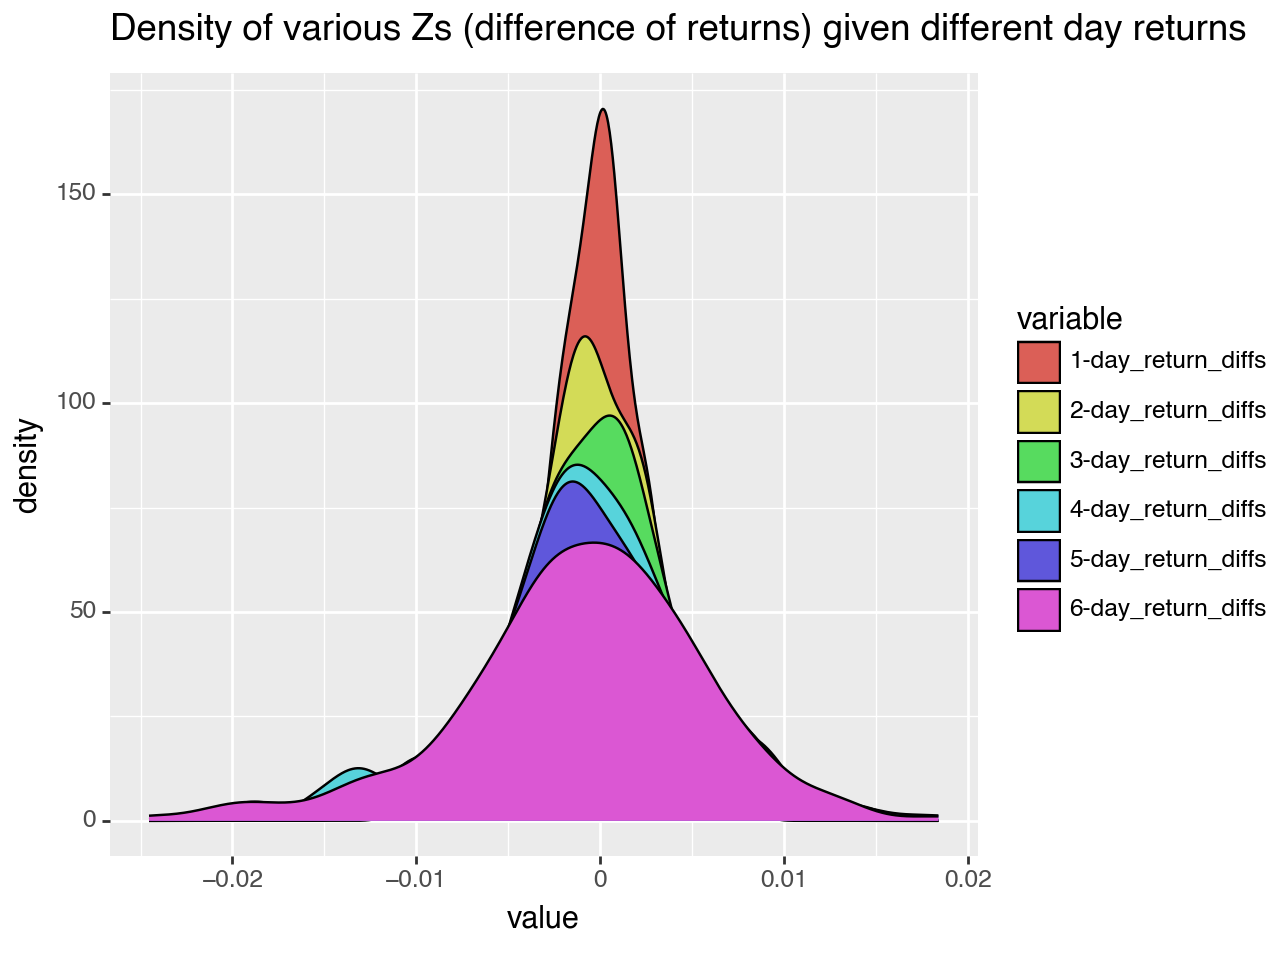

<Figure Size: (640 x 480)>

In [265]:
(
    p9.ggplot(long_mdf, p9.aes(x='value', fill='variable'))
    + p9.geom_density()
    + p9.ggtitle('Density of various Zs (difference of returns) given different day returns')
)

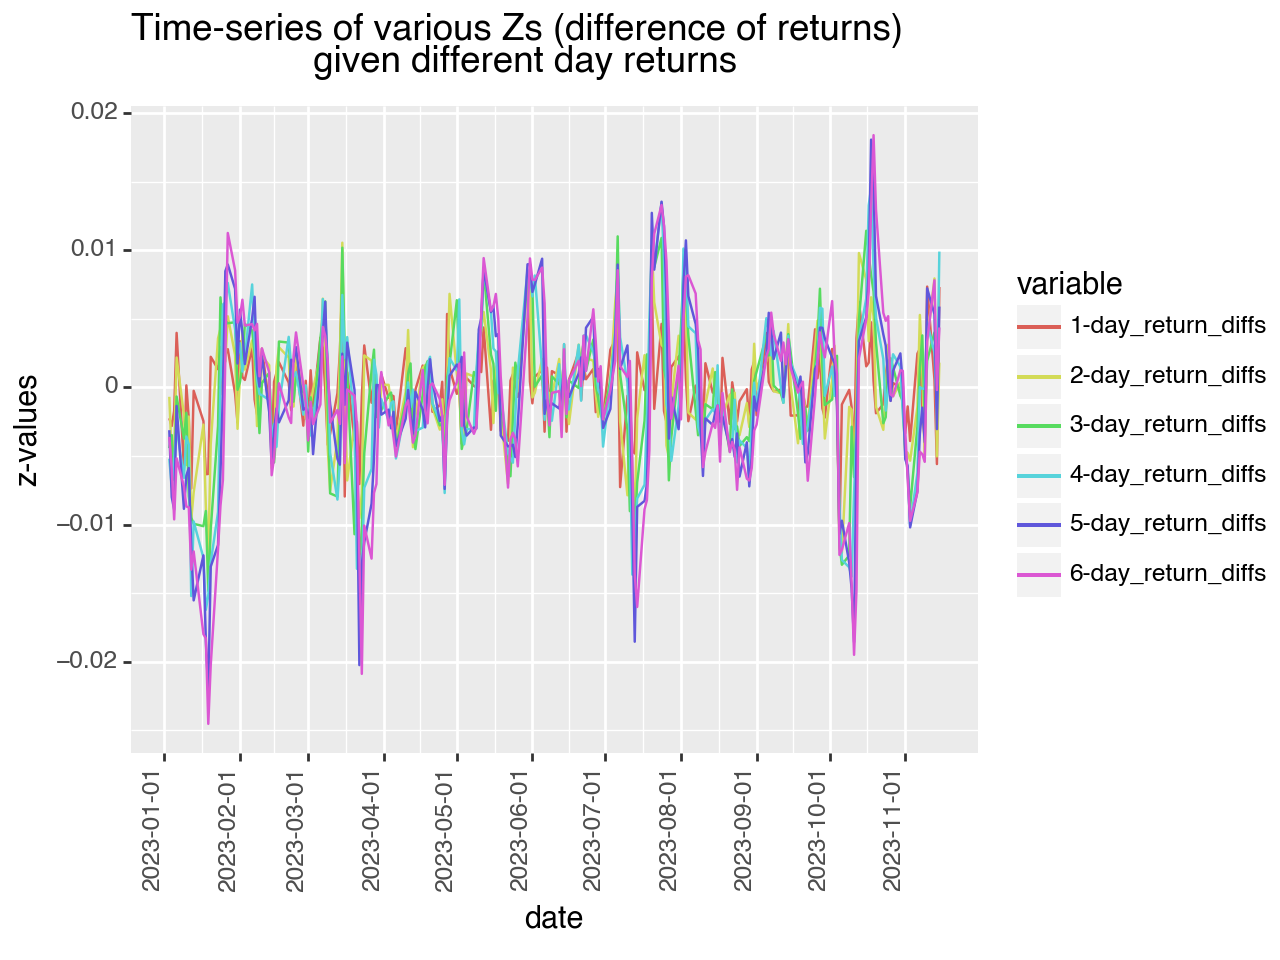

<Figure Size: (640 x 480)>

In [266]:
##### spread time trends
(
    p9.ggplot(time_mdf, p9.aes(x='date', y='value', color='variable', group='variable'))
    + p9.geom_line() 
    + p9.scale_x_datetime(breaks ="1 month")
    + p9.scale_y_continuous(name='z-values', limits=[time_mdf.value.min(), time_mdf.value.max()])
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle('Time-series of various Zs (difference of returns) \n \
                 given different day returns')
)

Densities:
1. It can be seen from the densities that variance increases in M -- of course, this makes sense as the market has a lot more priced in at t-1 than any number larger than 1. This in turn makes it appear as though 6-day return differences are much more normal -- and should offer riskier opportunities. On the other hand, since 1-day returns differences are much more concentrated about the mean, our mean-reversion assumption is most justifiable, thus making our spread trading strategy best suitable.
2. Interestingly, it seems like 2,4,5, and 6 day return differences are slightly right-skewed, indicating that the return on KXI tends to be slightly higher than the return on XLP, indicating shorting opportunities.
3. These results invite a look into the descriptive statistics of each distribution -- perhaps entering positions below 20th and above 80th percentiles (for g) and flattening at 30th and 70th percentiles (for j) would be succesful. These are just conjectures and will be tested below.
4. Further looking into kurtosis will also be helpful, but it seems like s, the proportion for our stop loss condition, should be lower for longer-day return differences as their variance can eat into our capital.

Time trends:
1. As expected by the densities, the variance of higher-day return differences are notably higher. What jumps out in this graph, however, is not only that the value of z changes as the days change, but its _direction_ changes as well (an example is 2023-02-01, where 2-day return differences are negative, but 4,5, and 6 day returns are not.) 
2. In general, though, it appears that the return differences tend to move together, meaning it should be possible to make a profit in all cases -- though the actual amount will vary.

In order to better understand the data, I have produced a dataframe of summary statistics as seen below. <br>
This dataframe will also be useful when running simulations using various parameters. <br>

In [267]:
# get subset of m-day return dataframe for summary statistics
desc_df = m_df.drop(['date', 'KXI_adj_close', 'XLP_adj_close'], axis=1)
described = desc_df[~desc_df['1-day_return_diffs'].isna()].describe(percentiles=list(np.arange(0.05, 1, 0.05)))
described.loc['variance'] = desc_df.var()
described.loc['kurtosis'] = desc_df.kurtosis()
# order index
ordered = ['mean', 'std', 'variance', 'kurtosis'] + [x for x in described.index if x not in ['mean', 'std', 'rsd', 'variance', 'kurtosis'] and x != 'count']
described = described.loc[ordered]
display(described)

,1-day_return_diffs,2-day_return_diffs,3-day_return_diffs,4-day_return_diffs,5-day_return_diffs,6-day_return_diffs
mean,-1.392815e-04,-0.000305,-0.000465,-0.000630,-0.000821,-0.000995
std,2.868177e-03,0.003957,0.004748,0.005505,0.006181,0.006619
variance,8.226441e-06,0.000016,0.000023,0.000030,0.000038,0.000044
kurtosis,1.317589e+00,0.787797,0.596195,0.637014,1.368943,1.124678
min,-1.090268e-02,-0.012443,-0.014843,-0.016219,-0.022288,-0.024540
5%,-4.817474e-03,-0.007047,-0.009511,-0.012270,-0.011684,-0.012526
10%,-3.343528e-03,-0.005030,-0.006485,-0.007260,-0.008300,-0.008759
15%,-2.584102e-03,-0.004031,-0.004523,-0.005218,-0.005757,-0.006841
20%,-2.252962e-03,-0.003029,-0.003645,-0.004234,-0.004904,-0.005443
25%,-1.804800e-03,-0.002470,-0.003049,-0.003494,-0.003743,-0.004555


An unexpected feature of this data is that the kurtosis of 1 day return is actually 2nd highest, followed by 5 and 6 day returns. <br>
It does expectedly have the lowest mean, median, and standard deviation of the data, though. <br>
5 day returns, also unexpectedly, have the highest kurtosis, even higher than 6 day returns, though with lower variance. This means that 5-day returns are more impacted by outliers, which introduces more risk than other options. <br>

Producing 5% percentiles will be useful for simulations going forward. <br>
In order to produce g and j pairs, we need to define some distance between g and j, which cannot be too big -- minimizing flattening opportunities, or too small -- minimizing profit amount. I will test these alongside values of g, which will be picked from the 5% percentiles. <br>
They can grouped in pairs of 9 (5% and 95%, 10% and 90%), and each pair will be tested for performance. <br>

Producing the right value for s is more difficult to properly determine. I will use a value ranging from 1% to 6% (standard trailing stop loss parameter according to Investopedia) the best performing value.

#### 4.2 Parameter search

Here I simulate throughout the limited space of possibilites for the parameters, and save all the trade info to analyze later on. The outcome of this simulation should indicate ideal paramters for the model

In [268]:
# make sure df is time series sorted
df = df.sort_values('date')

# Total capital -> max(N_t)*2
K = 2*df.N_t.max()

zeta = 0.00001 # trading cost

# strategy log
strat_log = pd.DataFrame(columns=['M', 'g', 'j', 's', 'zeta', 'strat_pnl'])

# s values
ss = np.round(np.linspace(start = 0.01, stop = 0.06, num=11), 3)

# dataframe to store all logs
all_logs = pd.DataFrame()

#loop through possible types of m-day returns
for m in m_vals:
    print(f'{m=}:')
    # get possible gs and js
    gjs = np.abs(described.loc['5%':'95%', f'{m}-day_return_diffs'])
    for g in tqdm(gjs):
        for j in gjs:
            if j >= g:
                continue
            skip_s = False
            for s in ss:
                if skip_s:
                    continue
                trade_log = simulate(trading_df=df, g=g, j=j, s = s, M=m, zeta=zeta, supress_print = True)
                strat_pnl = trade_log.pnl.sum()
                row = [m, g, j, s, zeta, strat_pnl]
                trade_log[['M', 'g', 'j', 's', 'zeta', 'strat_pnl']] = row
                all_logs = pd.concat((all_logs, trade_log))
                if not trade_log[trade_log.Reason == 'STOP LOSS'].shape[0]:
                    # stop loss not triggered -- increasing s will have no effect
                    skip_s = True
                    continue


m=1:


100%|██████████| 19/19 [01:54<00:00,  6.03s/it]


m=2:


100%|██████████| 19/19 [01:15<00:00,  3.95s/it]


m=3:


100%|██████████| 19/19 [01:12<00:00,  3.81s/it]


m=4:


100%|██████████| 19/19 [01:11<00:00,  3.75s/it]


m=5:


100%|██████████| 19/19 [01:06<00:00,  3.51s/it]


m=6:


100%|██████████| 19/19 [00:56<00:00,  2.98s/it]


Below I find the best parameter set for the highest returning strategy for each value of M, sorted by strategy returns: <br>
$\frac{strategy \quad pnl}{notional}$

In [319]:
# find totals
all_logs['strat_notionals'] = all_logs.groupby(['M', 'g', 'j', 's', 'zeta', 'strat_pnl'])['gross_cash'].transform('sum')/2
all_logs['num_trades'] = all_logs.groupby(['M', 'g', 'j', 's', 'zeta', 'strat_pnl']).transform('size')
all_logs['strat_returns'] = 100*all_logs.strat_pnl/all_logs.strat_notionals
all_logs['backtest_returns'] = 100*all_logs.strat_pnl/K
# find best performing notional return strategy sets for each value of m
#params_df = all_logs.sort_values('strat_returns', ascending=False).drop_duplicates('M')[['M', 'g', 'j', 's', 'zeta', 'num_trades', 'strat_notionals', 'strat_pnl', 'strat_returns', 'backtest_returns']]
params_df = all_logs.drop_duplicates(['M', 'g', 'j', 's']).nlargest(5, columns='strat_returns')[['M', 'g', 'j', 's', 'zeta', 'num_trades', 'strat_notionals', 'strat_pnl', 'strat_returns', 'backtest_returns']]
# getting the percentile number for optimal g and j values
params_df['g_percentile'] = params_df.apply(lambda x: described.index[round(described[f'{int(x.M)}-day_return_diffs'], 6).abs() == round(x.g, 6)].values[0], axis=1)
params_df['j_percentile'] = params_df.apply(lambda x: described.index[round(described[f'{int(x.M)}-day_return_diffs'], 6).abs() == round(x.j, 6)].values[0], axis=1)
# rounding numbers for readability
params_df[['g', 'j']] = params_df[['g', 'j']].round(6)

params_df

,M,g,j,s,zeta,num_trades,strat_notionals,strat_pnl,strat_returns,backtest_returns,g_percentile,j_percentile
0,4,0.012270,0.000012,0.015,0.00001,18,6.557432e+05,2883.363781,0.439709,0.011830,5%,55%
0,4,0.012270,0.000012,0.030,0.00001,24,8.708922e+05,3470.960839,0.398552,0.014241,5%,55%
0,4,0.012270,0.000012,0.020,0.00001,26,9.420445e+05,3618.473975,0.384109,0.014846,5%,55%
0,4,0.012270,0.000012,0.025,0.00001,26,9.420445e+05,3312.650251,0.351645,0.013591,5%,55%
0,5,0.011684,0.000182,0.015,0.00001,42,1.709857e+06,4604.414163,0.269287,0.018891,5%,55%


Below I select the best parameter set for the highest returning strategy for each value of M, sorted by backtest returns: <br>
$\frac{strategy \quad pnl}{K}$ where $K = 2*max(N_t)$

In [320]:
# find best performing back test return strategy sets for each value of m
params_df = all_logs.drop_duplicates(['M', 'g', 'j', 's']).nlargest(5, columns='backtest_returns')[['M', 'g', 'j', 's', 'zeta', 'num_trades', 'strat_notionals', 'strat_pnl', 'strat_returns', 'backtest_returns']]
# getting the percentile number for optimal g and j values
params_df['g_percentile'] = params_df.apply(lambda x: described.index[round(described[f'{int(x.M)}-day_return_diffs'], 6).abs() == round(x.g, 6)].values[0], axis=1)
params_df['j_percentile'] = params_df.apply(lambda x: described.index[round(described[f'{int(x.M)}-day_return_diffs'], 6).abs() == round(x.j, 6)].values[0], axis=1)
# rounding numbers for readability
params_df[['g', 'j']] = params_df[['g', 'j']].round(6)

params_df

,M,g,j,s,zeta,num_trades,strat_notionals,strat_pnl,strat_returns,backtest_returns,g_percentile,j_percentile
0,1,0.001385,0.000000,0.020,0.00001,336,1.456402e+07,6864.420299,0.047133,0.028163,30%,50%
0,1,0.001374,0.000000,0.020,0.00001,336,1.456402e+07,6864.420299,0.047133,0.028163,75%,50%
0,1,0.001002,0.000000,0.025,0.00001,388,1.663495e+07,6500.337472,0.039076,0.026669,70%,50%
0,1,0.001045,0.000000,0.025,0.00001,380,1.635314e+07,6031.624727,0.036884,0.024746,35%,50%
0,2,0.006361,0.000066,0.020,0.00001,72,2.964909e+06,5730.546876,0.193279,0.023511,95%,55%


#### 4.3 Return analysis

These results are rather surprising, especially since they do not align. The best strategy to maximize strategy returns is M=4, which is not even top 5 for maximizing return on capital. Converesely, the best strategy for maximizing return on capital is M=1, which is not even top 5 for maximizing strategy returns. <br>
The discrepancy is mainly due to the significantly different notionals. Maximizing return on capital results in strategies that traded at least an order of magnitude more cash -- this is also seen in the significantly different number of trades in the two types of return maximizing strategy sets. <br>
A better understanding of the discrepancy also lies in looking at their ideal g and j values. Notably, both strategy sets' ideal j values lie around their medians -- around 0. The ideal g values exhibit a more interesting pattern. For the strategy return maximizing set, they lie at the tails: at the 5th (and given symmetry of g, 95th) percentiles. For the return on capital maximizing set, are much closer to the center of the data between 35th and 25th (65th and 75th) percentiles. The exception is the strategy for M=2, whose setting profile closely resembles that of the strategy-maximizing set.

These patterns make sense -- strategies with highest returns on notionals capitalize on rarer events, and so protect their downside. They are trading with more uncertainty (which is also why they are those whose return data is from farther back). Strategies with higher returns on capital are more open to risk and trade much more frequently, which is why their returns data are more short-term.<br>

The constraints of the sizing of our positions is also partially responsible for the discrepancy in the return performances. Given the higher average returns on notionals, and the much lower frequency trades, a much larger position size would lead to significantly higher returns on capital as well -- the size of the position should also have been a function of the likelihood of a specific return difference, not just the trading volume.

Identifying and creating dataframe of 5 strategies with highest return on capital

In [514]:
strat_id = 0

ret_df = pd.DataFrame()

# filter trade logs using best strategies and assign identifier for future analyses
for i, row in params_df.iterrows():
    m = row.M
    g = np.round(row.g, 6)
    j = np.round(row.j, 6)
    s = row.s
    strat_notionals = row.strat_notionals
    strat_returns = row.strat_returns
    sub_df = all_logs[(all_logs.M == m) & (np.round(all_logs.g, 6) == g) & (np.round(all_logs.j, 6) == j) & (all_logs.s == s)]
    sub_df = sub_df[sub_df.position_status == 'CLOSE']
    sub_df = sub_df[['date', 'pnl', 'M', 'g', 'j', 's', 'zeta', 'num_trades', 'gross_cash','strat_pnl', 'strat_notionals', 'strat_returns', 'backtest_returns']]
    sub_df['strat_id'] = strat_id
    ret_df = pd.concat([ret_df, sub_df])
    # sanity check 
    if sub_df[sub_df[['date', 'pnl']].duplicated()].shape[0]:
        display(sub_df)
        break
    strat_id += 1

ret_df

,date,pnl,M,g,j,s,zeta,num_trades,gross_cash,strat_pnl,strat_notionals,strat_returns,backtest_returns,strat_id
1,2022-01-04,12.119305,1,0.001385,4.923501e-08,0.02,0.00001,336,57530.765040,6864.420299,1.456402e+07,0.047133,0.028163,0
3,2022-01-11,-109.723120,1,0.001385,4.923501e-08,0.02,0.00001,336,67276.393182,6864.420299,1.456402e+07,0.047133,0.028163,0
5,2022-01-13,53.963525,1,0.001385,4.923501e-08,0.02,0.00001,336,48247.777578,6864.420299,1.456402e+07,0.047133,0.028163,0
7,2022-01-20,-17.596259,1,0.001385,4.923501e-08,0.02,0.00001,336,46633.325493,6864.420299,1.456402e+07,0.047133,0.028163,0
9,2022-01-21,169.345410,1,0.001385,4.923501e-08,0.02,0.00001,336,76965.336299,6864.420299,1.456402e+07,0.047133,0.028163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2023-07-10,378.392482,2,0.006361,6.570338e-05,0.02,0.00001,72,111022.908046,5730.546876,2.964909e+06,0.193279,0.023511,4
65,2023-07-20,135.791508,2,0.006361,6.570338e-05,0.02,0.00001,72,80466.819998,5730.546876,2.964909e+06,0.193279,0.023511,4
67,2023-09-20,198.609262,2,0.006361,6.570338e-05,0.02,0.00001,72,70047.767453,5730.546876,2.964909e+06,0.193279,0.023511,4
69,2023-10-13,133.259344,2,0.006361,6.570338e-05,0.02,0.00001,72,74599.074452,5730.546876,2.964909e+06,0.193279,0.023511,4


Merging best performing trade logs to SVOL and fama french data

In [515]:
# setting up volatility dataframe
vol_df = df[['date', 'SVOL_adj_close']]
display(vol_df.head())
# merge with trade log dataframe
ret_df['SVOL'] = ret_df.date.map(vol_df.set_index('date')['SVOL_adj_close'])
# merge with fama french 
ret_df['monthyear'] =  pd.to_datetime(ret_df['date']).dt.strftime('%Y%m')
ret_df = ret_df.merge(ff_df, left_on='monthyear', right_on='date')
ret_df.drop(columns=['monthyear', 'date_y'], axis=1, inplace=True)
ret_df.rename({'date_x':'date'}, axis=1, inplace=True)
ret_df['ret'] = 100*ret_df.pnl/ret_df.gross_cash
display(ret_df.head())
# make long df of fama french and SVOL
ret_long = pd.melt(ret_df[['date', 'SVOL', 'Mkt-RF', 'SMB', 'HML', 'RF']].drop_duplicates(), id_vars='date')


,date,SVOL_adj_close
15,2021-12-23,24.071427
16,2021-12-27,24.094382
17,2021-12-28,24.138935
18,2021-12-29,24.343880
19,2021-12-30,24.299237


,date,pnl,M,g,j,s,zeta,num_trades,gross_cash,strat_pnl,strat_notionals,strat_returns,backtest_returns,strat_id,SVOL,Mkt-RF,SMB,HML,RF,ret
0,2022-01-04,12.119305,1,0.001385,4.923501e-08,0.02,0.00001,336,57530.765040,6864.420299,1.456402e+07,0.047133,0.028163,0,24.575556,-5.58,-4.16,11.96,0.0,0.021066
1,2022-01-11,-109.723120,1,0.001385,4.923501e-08,0.02,0.00001,336,67276.393182,6864.420299,1.456402e+07,0.047133,0.028163,0,24.547577,-5.58,-4.16,11.96,0.0,-0.163093
2,2022-01-13,53.963525,1,0.001385,4.923501e-08,0.02,0.00001,336,48247.777578,6864.420299,1.456402e+07,0.047133,0.028163,0,24.299326,-5.58,-4.16,11.96,0.0,0.111847
3,2022-01-20,-17.596259,1,0.001385,4.923501e-08,0.02,0.00001,336,46633.325493,6864.420299,1.456402e+07,0.047133,0.028163,0,23.497368,-5.58,-4.16,11.96,0.0,-0.037733
4,2022-01-21,169.345410,1,0.001385,4.923501e-08,0.02,0.00001,336,76965.336299,6864.420299,1.456402e+07,0.047133,0.028163,0,23.256781,-5.58,-4.16,11.96,0.0,0.220028


Make long dataset for fama french factors and SVOL

Plot of time series of each return against SVOl and fama-french factors

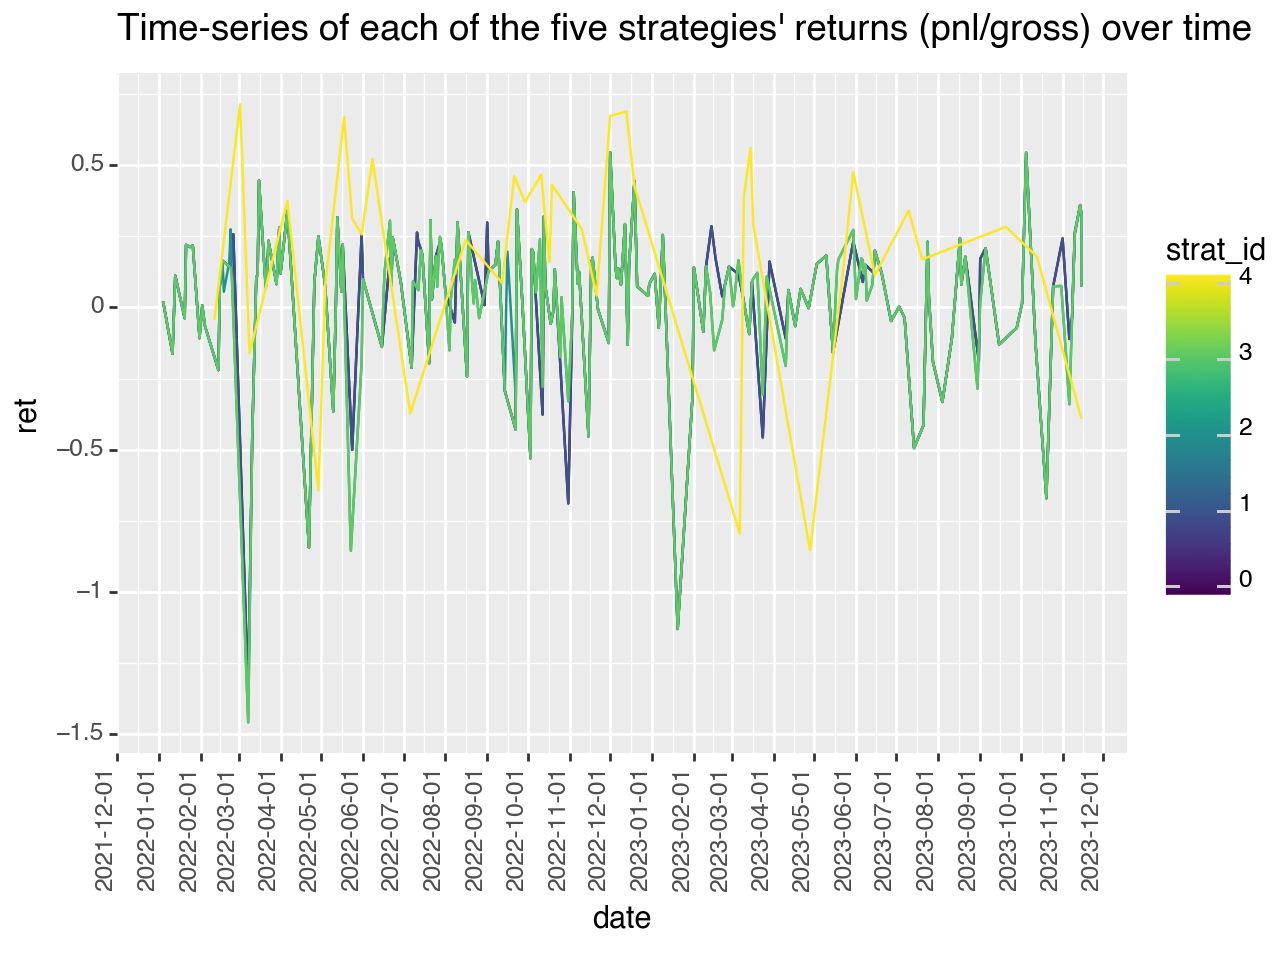

<Figure Size: (640 x 480)>

In [516]:
(
    p9.ggplot(ret_df, p9.aes(x='date', y='ret', color='strat_id', group='strat_id'))
    + p9.geom_line()  
    + p9.scale_x_datetime(breaks = '1 month')
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle("Time-series of each of the five strategies' returns (pnl/gross) over time")
)


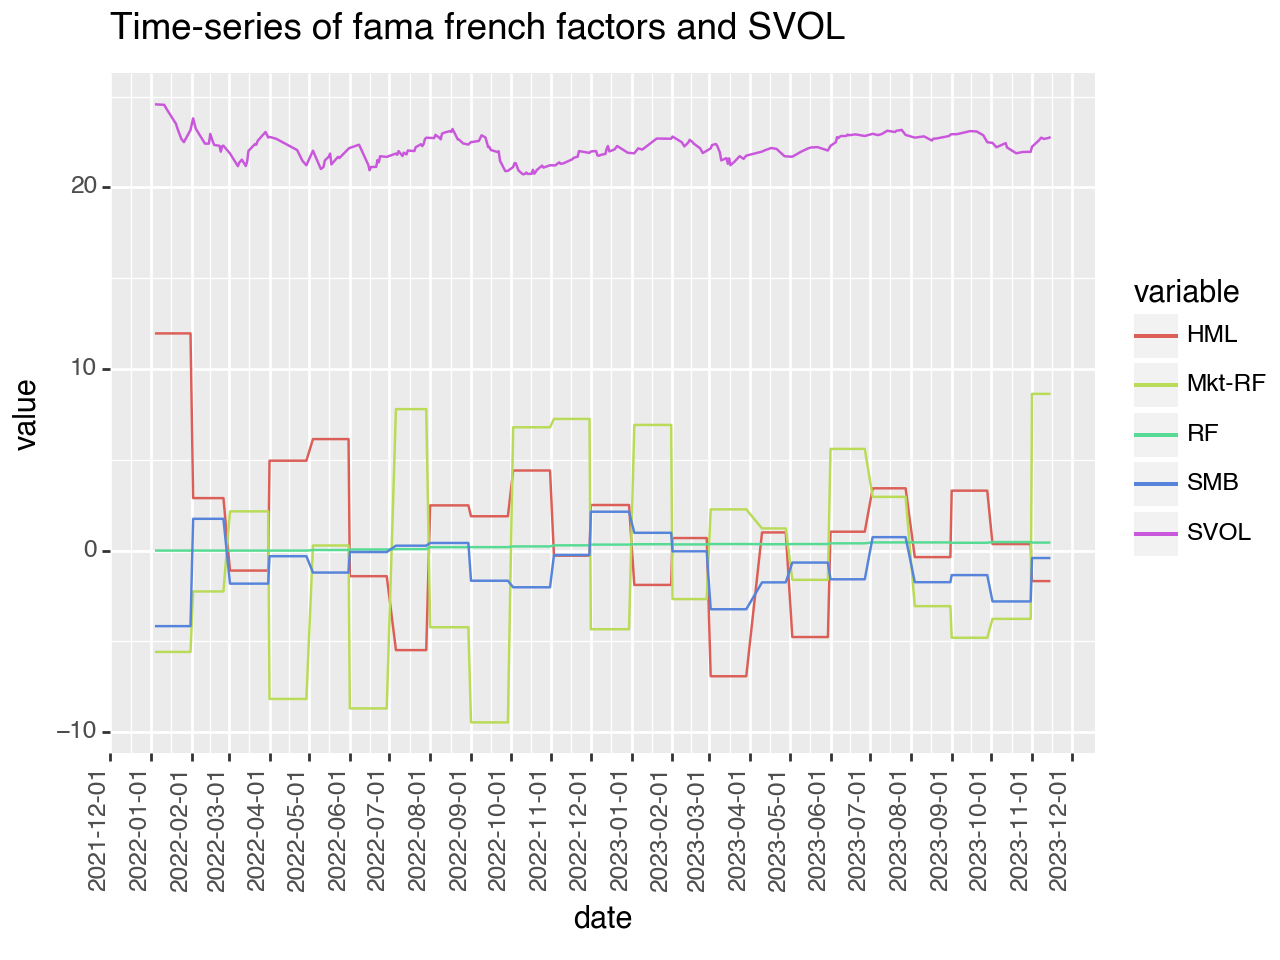

<Figure Size: (640 x 480)>

In [511]:
(
    p9.ggplot(ret_long, p9.aes(x='date', y='value', color='variable', group='variable'))
    + p9.geom_line()
    + p9.scale_x_datetime(breaks = '1 month')
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle("Time-series of fama french factors and SVOL")
)


It appears that the returns of the best performing strategy set (id = 0) follows a very similar trend to the fama french Mkt-RF -- the excess return on the market portfolio -- which brings into question whether the observed returns were simply correlations with the market. The comparison to fama french factors is somewhat limited due to my trades being daily and the factors monthly, but they do capture monthly trends nonetheless.<br>
Similarly, SVOL seems to also have a relationship with all 5 strategies' returns, though it seems to be more of an inverse relationship. This makes sense given SVOL is meant to correspond to the inverse of the performance of the Cboe Volatility Index (VIX). <br>

In [526]:
ret_df['avg_ff_rf'] = ret_df.groupby('strat_id')['RF'].transform('mean')
ret_df['sharpe'] = (ret_df.backtest_returns - ret_df.avg_ff_rf)/np.sqrt(np.square(ret_df.backtest_returns))
ret_df.drop_duplicates(subset='strat_id')


,date,pnl,M,g,j,s,zeta,num_trades,gross_cash,strat_pnl,...,strat_id,SVOL,Mkt-RF,SMB,HML,RF,ret,avg_ff_rf,mod_sharpe,sharpe
0,2022-01-04,12.119305,1,0.001385,4.923501e-08,0.020,0.00001,336,57530.765040,6864.420299,...,0,24.575556,-5.58,-4.16,11.96,0.0,0.021066,0.235119,-1.0,-7.348488
8,2022-01-04,12.119305,1,0.001374,4.923501e-08,0.020,0.00001,336,57530.765040,6864.420299,...,1,24.575556,-5.58,-4.16,11.96,0.0,0.021066,0.235119,-1.0,-7.348488
16,2022-01-04,12.119305,1,0.001002,4.923501e-08,0.025,0.00001,388,57530.765040,6500.337472,...,2,24.575556,-5.58,-4.16,11.96,0.0,0.021066,0.235206,-1.0,-7.819353
24,2022-01-04,12.119305,1,0.001045,4.923501e-08,0.025,0.00001,380,57530.765040,6031.624727,...,3,24.575556,-5.58,-4.16,11.96,0.0,0.021066,0.238158,-1.0,-8.623976
62,2022-02-11,-29.064521,2,0.006361,6.570338e-05,0.020,0.00001,72,67276.393182,5730.546876,...,4,22.409899,-2.25,1.75,2.89,0.0,-0.043202,0.234167,-1.0,-8.959852


As can be seen above, all strategies have a negative sharpe ratio, which means the return of the portfolios is much less than the risk-free rate of return. This indicates that, though succesful, these strategies simply cannot beat the market return, and require more varying conditions for trading, such as freedom to size positions.